## For opening Camera
you capture your image here

In [129]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


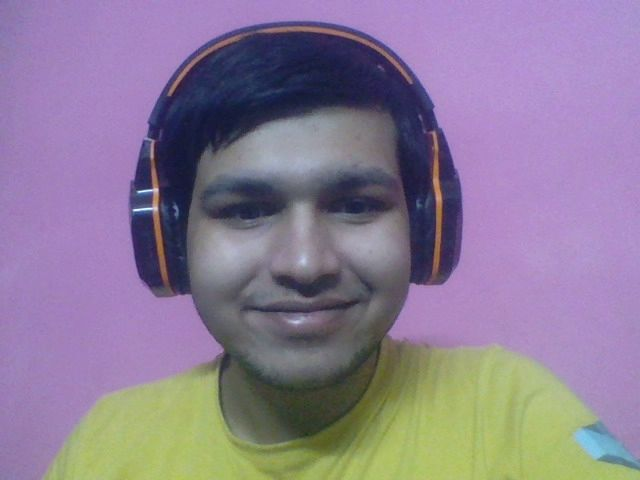

In [130]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Importing the libraries

In [144]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2 # I tried using this but was not be able 
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

## Code for DL training of the dataset
Here you can see how i trained my model

In [ ]:
train_dir = "../input/emotion-detection-fer/train" 
test_dir = "../input/emotion-detection-fer/test" 

In [ ]:
img_size = 48

In [ ]:
train_datagen = ImageDataGenerator(#rotation_range = 180,        using Image DATA generator to transform the images
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,                   # flowing the data from the directory through the datagen object for transformation
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

In [ ]:
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(                                    # Compiling the model 
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [ ]:
epochs = 60
batch_size = 64

In [ ]:
model.summary()

In [ ]:
history = model.fit(x = train_generator,epochs = epochs,validation_data = validation_generator)

In [ ]:
model.save('model_optimal.h5')

## Actual code that you can run :)

In [150]:
new_model = tf.keras.models.load_model('/content/model_optimal (2).h5')  #since i have already trained the model you can find the model in my GITHUB repo and upload it here

In [151]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

(48, 48)


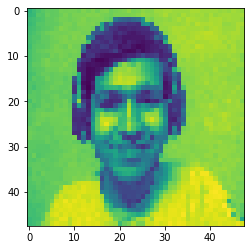

In [152]:
img = image.load_img("/content/photo.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape)

In [153]:
img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = new_model.predict(img)
result = list(result[0])
print(result)

[0.95586663, 0.0, 6.178816e-09, 0.0, 4.8804987e-34, 0.04413341, 0.0]


In [154]:
img_index = result.index(max(result))
print(label_dict[img_index])

Angry


In [155]:
# This is the openCV code for live face-emotion detection
# here i have used haarcascade to find the face and crop it
import cv2


path = "haarcascade_frontalface_default.xml"
font_scale = 1.5
font = cv2.FONT_HERSHEY_PLAIN

rectangle_bgr = (255,255,255)

img = np.zeros((500,500))

text = "some"

(text_width, text_height) = cv2.getTextSize(text, font, fontScale = font_scale, thickness = 1)[0]

text_offset_x = 10
text_offset_y = img.shape[0] - 25

box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height - 2))
cv2.rectangle(img, box_coords[0], box_coords[1], rectangle_bgr, cv2.FILLED)
cv2.putText(img, text, (text_offset_x, text_offset_y), font, fontScale = font_scale, color = (0,0,0), thickness =1)

cap = cv2.VideoCapture(1)

if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open Webcam")
    
while True:
    ref, frame = cap.read()
    
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray, 1.1, 4)
    for x, y, w, h in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x,y), (x+w, y+h), (255, 0, 0), 2)
        facess = faceCascade.detectMultiScale(roi_gray)
        if len(facess) == 0:
            print("Face not detected")
        else:
            for (ex,ey,ew,eh) in facess:
                face_roi = roi_gray[ey: ey+eh, ex : ex+ew]
                
    img = np.expand_dims(roi_gray,axis = 0) #makes image shape (1,48,48)
    img = img.reshape(1,48,48,1)
    result = new_model.predict(img)
    Predictions = list(result[0])
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    Predictions = new_model.predict(final_image)
    
    font_scale = 1.5
    
    font = cv2.FONT_HERSHEY_PLAIN
    
    if(np.argmax(Predictions) == 0):
        status = "Angry"
        
        x1, y1, w1, h1 = 0,0,175,75
        cv2.rectangle(frame, (x1, x1), (x1+ w1, y1 + h1), (0,0,0), -1)
        
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/10)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,225), 2)
        
        cv2.putText(frame, status, (100,150), font, 3, (0,0,225), 2, cv2.LINE_4)
        
        cv2.rectangle(frame, (x,y), (x + w, y + h), (0, 0, 225))
    elif(np.argmax(Predictions) == 1):
        status = "Disgust"
        
        x1, y1, w1, h1 = 0,0,175,75
        cv2.rectangle(frame, (x1, x1), (x1+ w1, y1 + h1), (0,0,0), -1)
        
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/10)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,225), 2)
        
        cv2.putText(frame, status, (100,150), font, 3, (0,0,225), 2, cv2.LINE_4)
        
        cv2.rectangle(frame, (x,y), (x + w, y + h), (0, 0, 225))
    elif(np.argmax(Predictions) == 2):
        status = "Fear"
        
        x1, y1, w1, h1 = 0,0,175,75
        cv2.rectangle(frame, (x1, x1), (x1+ w1, y1 + h1), (0,0,0), -1)
        
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/10)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,225), 2)
        
        cv2.putText(frame, status, (100,150), font, 3, (0,0,225), 2, cv2.LINE_4)
        
        cv2.rectangle(frame, (x,y), (x + w, y + h), (0, 0, 225))
    elif(np.argmax(Predictions) == 3):
        status = "Happy"
        
        x1, y1, w1, h1 = 0,0,175,75
        cv2.rectangle(frame, (x1, x1), (x1+ w1, y1 + h1), (0,0,0), -1)
        
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/10)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,225), 2)
        
        cv2.putText(frame, status, (100,150), font, 3, (0,0,225), 2, cv2.LINE_4)
        
        cv2.rectangle(frame, (x,y), (x + w, y + h), (0, 0, 225))
    elif(np.argmax(Predictions) == 5):
        status = "Sad"
        
        x1, y1, w1, h1 = 0,0,175,75
        cv2.rectangle(frame, (x1, x1), (x1+ w1, y1 + h1), (0,0,0), -1)
        
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/10)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,225), 2)
        
        cv2.putText(frame, status, (100,150), font, 3, (0,0,225), 2, cv2.LINE_4)
        
        cv2.rectangle(frame, (x,y), (x + w, y + h), (0, 0, 225))
    elif(np.argmax(Predictions) == 6):
        status = "Surprise"
        
        x1, y1, w1, h1 = 0,0,175,75
        cv2.rectangle(frame, (x1, x1), (x1+ w1, y1 + h1), (0,0,0), -1)
        
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/10)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,225), 2)
        
        cv2.putText(frame, status, (100,150), font, 3, (0,0,225), 2, cv2.LINE_4)
        
        cv2.rectangle(frame, (x,y), (x + w, y + h), (0, 0, 225))
    else:
        status = "Nuetral"
        
        x1, y1, w1, h1 = 0,0,175,75
        cv2.rectangle(frame, (x1, x1), (x1+ w1, y1 + h1), (0,0,0), -1)
        
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/10)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,225), 2)
        
        cv2.putText(frame, status, (100,150), font, 3, (0,0,225), 2, cv2.LINE_4)
        
        cv2.rectangle(frame, (x,y), (x + w, y + h), (0, 225, 0))
    
    
    cv2.imshow("face emotion recognition", frame)
    
    if cv2.waitKey(2) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

OSError: ignored